## 📁 1. Install Required Libraries

In [1]:
pip install tensorflow opencv-python matplotlib tqdm pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 📥 2. Load Dataset & Labels

In [ ]:
# Path dataset
img_dir = 'datasets/img_align_celeba'
attr_path = 'datasets/list_attr_celeba.txt'
max_images = 50000  # naikin dari 20k ke 30k atau 50k untuk hasil lebih baik
img_size = 64

# Baca label
df_attr = pd.read_csv(attr_path, delim_whitespace=True, skiprows=1)
df_attr['Smiling'] = df_attr['Smiling'].apply(lambda x: 1 if x == 1 else 0)

# Ambil 50.000 gambar pertama
df_attr = df_attr.head(max_images)
print("Jumlah data:", len(df_attr))
print(df_attr['Smiling'].value_counts())


C:\Users\fujitsu\AppData\Local\Temp\ipykernel_627188\2242314264.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_attr = pd.read_csv(attr_path, delim_whitespace=True, skiprows=1)


Jumlah data: 50000
Smiling
0    26162
1    23838
Name: count, dtype: int64


- Dataset used: CelebA (CelebFaces Attributes Dataset)
- Focus label: Smiling (1 = smiling, 0 = not smiling)
- Number of images used: First 50,000 images
- All images will be resized to 64x64 in grayscale

## 🧹 3. Preprocess Images and Labels

In [4]:
def load_images_and_labels(df, img_dir, img_size):
    X, y = [], []

    for img_name, label in tqdm(df['Smiling'].items()):
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            X.append(resized)
            y.append(label)

    X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0
    y = np.array(y)

    return X, y

X, y = load_images_and_labels(df_attr, img_dir, img_size)
print("Shape:", X.shape, y.shape)


50000it [03:59, 209.05it/s]


Shape: (50000, 64, 64, 1) (50000,)


- Convert each image to grayscale
- Resize to fixed size (64x64)
- Normalize pixel values (range 0 - 1)
- Extract labels from list_attr_celeba.txt

## 📊 4. Split Dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


- Data split: 80% training, 20% testing
- Done using train_test_split from sklearn

## 🧠 5. CNN Model Architecture for Smile Detection

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\fujitsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

A simple CNN model with:
- 3 Conv2D + MaxPooling layers
- Dropout layers to prevent overfitting
- Final Dense layer with sigmoid activation

Loss function: binary_crossentropy

Optimizer: Adam, learning rate = 0.0001

## 📈 6. Train the Model

In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=30,
    validation_data=(X_test, y_test)
)


C:\Users\fujitsu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 92s 141ms/step - accuracy: 0.5237 - loss: 0.6918 - val_accuracy: 0.6316 - val_loss: 0.6567
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.6009 - loss: 0.6645 - val_accuracy: 0.6544 - val_loss: 0.6333
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 145ms/step - accuracy: 0.6199 - loss: 0.6517 - val_accuracy: 0.6807 - val_loss: 0.6032
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 140ms/step - accuracy: 0.6499 - loss: 0.6284 - val_accuracy: 0.7521 - val_loss: 0.5303
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.6938 - loss: 0.5849 - val_accuracy: 0.7475 - val_loss: 0.4964
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 90s 144ms/step - accuracy: 0.7396 - loss: 0.5303 - val_accuracy: 0.7764 - val_loss: 0.4505
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - accuracy: 0.7705 - loss: 0.4837 - val_accuracy: 0.8195 - val_loss: 0.3834
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 99s 158ms/step - accuracy: 0.7894 - loss: 0

- Data augmentation using ImageDataGenerator
- Number of epochs: 30
- Batch size: 64
- Training history saved for visualization

## 💾 7. Save the Trained Model

The trained model is saved as .h5 file:

In [8]:
model.save("trained_model/smile_model_cnn.h5")

## 📊 8. Visualize Training Accuracy

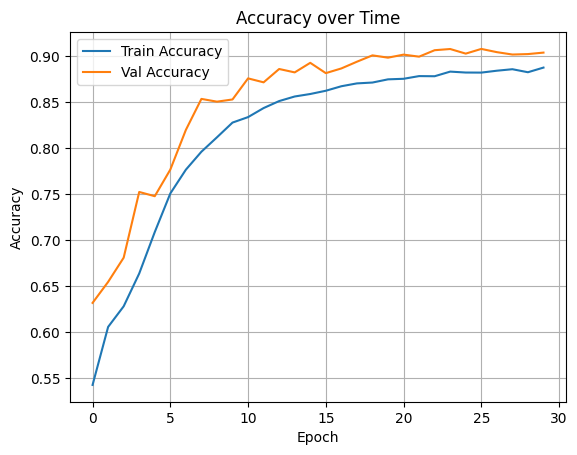

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Time')
plt.legend()
plt.grid()
plt.show()

Plotting graphs for:
- Training accuracy
- Validation accuracy

Purpose: To monitor the model's performance over time

## 📷 9. Predict on a New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Smile Probability: 0.15153445
😐 Not Smile


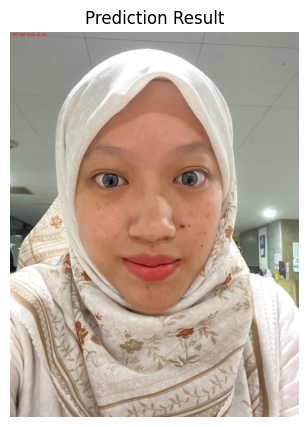

In [15]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ukuran input sesuai saat training
img_size = 64

# Load model
model = load_model('trained_model/smile_model_cnn.h5')

# Load satu gambar baru untuk prediksi
img_path = 'predict_image/nada2.jpg'  # Ganti dengan path gambar kamu
img = cv2.imread(img_path)

# Cek apakah gambar berhasil dibaca
if img is None:
    print("❌ Gambar tidak ditemukan.")
else:
    # Preprocessing: Grayscale, resize, normalisasi
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (img_size, img_size))
    input_img = resized.reshape(1, img_size, img_size, 1) / 255.0

    # Prediksi
    pred = model.predict(input_img)
    score = pred[0][0]

    if score > 0.5:
        label = "😊 Smile"
        color = (0, 255, 0)
    else:
        label = "😐 Not Smile"
        color = (0, 0, 255)

    print("Smile Probability:", score)
    print(label)

    # Tambahkan label ke gambar (asli, bukan grayscale)
    annotated_img = img.copy()
    cv2.putText(annotated_img, f"{label} ({score:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Konversi BGR ke RGB untuk matplotlib
    rgb_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # Tampilkan di Jupyter
    plt.figure(figsize=(5, 5))
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title("Prediction Result")
    plt.show()


The image is preprocessed same as training data:
- Converted to grayscale
- Resized to 64x64
- Normalized

Prediction:
- Output is a probability (0.0 - 1.0)
- If > 0.5 → Smile 😊
- If ≤ 0.5 → Not Smile 😐

The prediction label and confidence score are drawn on the image